In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params

dataset_name="caltech101"
 
model_name="EfficientNetb7"
version = "b7"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=2
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb7 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 5

In [2]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = math.ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*math.ceil(int(channels*width_factor) / 4)
            layers_repeats = math.ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.InvertedResidualBlock'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_l

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb720211231002419
grandstore_string:
grandstore/caltech101_EfficientNetb720211231002419.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=240,
                    minepoch=120,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.000
Training Loss: 43016066.7118 	Validation Loss: 5032.8988

Running epoch: 2


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.917
Training Loss: 42167789.1585 	Validation Loss: 4967.5563

Running epoch: 3


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.833
Training Loss: 41862303.4068 	Validation Loss: 5046.6377

Running epoch: 4


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.000
Training Loss: 41746340.2768 	Validation Loss: 5017.4293

Running epoch: 5


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 41911653.8185 	Validation Loss: 5031.5013

Running epoch: 6


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 41600903.8909 	Validation Loss: 5030.5551

Running epoch: 7


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41993648.2996 	Validation Loss: 5014.0267

Running epoch: 8


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.917
Training Loss: 41911642.3296 	Validation Loss: 5047.8019

Running epoch: 9


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 7.333
Training Loss: 41825201.8799 	Validation Loss: 5024.6867

Running epoch: 10


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.417
Training Loss: 41890603.9856 	Validation Loss: 5047.8473

Running epoch: 11


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.167
Training Loss: 41833746.2706 	Validation Loss: 5039.3832

Running epoch: 12


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 15.583
Training Loss: 41878989.7223 	Validation Loss: 4914.0760

Running epoch: 13


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.583
Training Loss: 41910663.9166 	Validation Loss: 4993.3414

Running epoch: 14


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 9.000
Training Loss: 41925677.6461 	Validation Loss: 5023.0435

Running epoch: 15


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 9.083
Training Loss: 42077177.4716 	Validation Loss: 5029.8225

Running epoch: 16


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 9.250
Training Loss: 41986458.2650 	Validation Loss: 5008.3743

Running epoch: 17


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.583
Training Loss: 41995199.1886 	Validation Loss: 5010.1182

Running epoch: 18


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 41972173.3266 	Validation Loss: 4996.3069

Running epoch: 19


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 9.000
Training Loss: 41694747.4755 	Validation Loss: 5024.2031

Running epoch: 20


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.833
Training Loss: 41594304.9192 	Validation Loss: 5119.4454

Running epoch: 21


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.333
Training Loss: 41638292.5099 	Validation Loss: 6126.4652

Running epoch: 22


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.500
Training Loss: 41138407.7081 	Validation Loss: 4856.7855

Running epoch: 23


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 18.667
Training Loss: 41125165.7646 	Validation Loss: 4870.9558

Running epoch: 24


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 17.917
Training Loss: 40830329.4194 	Validation Loss: 4890.0758

Running epoch: 25


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 15.833
Training Loss: 41077305.2155 	Validation Loss: 4908.1070

Running epoch: 26


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 20.083
Training Loss: 41029844.4453 	Validation Loss: 4657.1014

Running epoch: 27


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 21.667
Training Loss: 40114792.0111 	Validation Loss: 4544.1114

Running epoch: 28


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 21.583
Training Loss: 38821252.8457 	Validation Loss: 4513.6111

Running epoch: 29


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 28.250
Training Loss: 37333922.1595 	Validation Loss: 4131.8514

Running epoch: 30


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 29.917
Training Loss: 35906431.3166 	Validation Loss: 3964.4293

Running epoch: 31


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 33.667
Training Loss: 34584946.8220 	Validation Loss: 3796.1226

Running epoch: 32


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 34.500
Training Loss: 33789046.5447 	Validation Loss: 3744.7155

Running epoch: 33


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.500
Training Loss: 32719352.9238 	Validation Loss: 3563.9924

Running epoch: 34


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.417
Training Loss: 31640010.2614 	Validation Loss: 3607.9273

Running epoch: 35


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.083
Training Loss: 30600510.6635 	Validation Loss: 3629.8291

Running epoch: 36


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 41.417
Training Loss: 29797720.8005 	Validation Loss: 3274.9004

Running epoch: 37


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 42.000
Training Loss: 28825192.8918 	Validation Loss: 3247.1696

Running epoch: 38


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 43.250
Training Loss: 27559163.0392 	Validation Loss: 3148.7245

Running epoch: 39


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.000
Training Loss: 26623416.8408 	Validation Loss: 2986.9726

Running epoch: 40


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.750
Training Loss: 25841339.9054 	Validation Loss: 2967.4145

Running epoch: 41


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.833
Training Loss: 24519165.6694 	Validation Loss: 2926.7075

Running epoch: 42


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.833
Training Loss: 23365505.0419 	Validation Loss: 2826.3519

Running epoch: 43


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.667
Training Loss: 22676323.6804 	Validation Loss: 2752.5394

Running epoch: 44


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.083
Training Loss: 21453616.6552 	Validation Loss: 2608.0715

Running epoch: 45


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.833
Training Loss: 20553380.9216 	Validation Loss: 2563.3927

Running epoch: 46


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.500
Training Loss: 19632847.3971 	Validation Loss: 2535.6917

Running epoch: 47


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.250
Training Loss: 18353134.0888 	Validation Loss: 2435.9372

Running epoch: 48


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 55.250
Training Loss: 17599764.7654 	Validation Loss: 2441.1797

Running epoch: 49


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.583
Training Loss: 16729390.1684 	Validation Loss: 2547.9798

Running epoch: 50


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.333
Training Loss: 15064591.6980 	Validation Loss: 2500.4332

Running epoch: 51


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.750
Training Loss: 14041158.4929 	Validation Loss: 2362.5597

Running epoch: 52


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 12891160.5917 	Validation Loss: 2427.2471

Running epoch: 53


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.000
Training Loss: 12036706.1367 	Validation Loss: 2409.3033

Running epoch: 54


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.250
Training Loss: 10803168.4473 	Validation Loss: 2440.1486

Running epoch: 55


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.250
Training Loss: 9957464.3897 	Validation Loss: 2496.4444

Running epoch: 56


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.250
Training Loss: 8935020.1796 	Validation Loss: 2452.1545

Running epoch: 57


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.000
Training Loss: 7679141.7967 	Validation Loss: 2589.8897

Running epoch: 58


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 6908821.6407 	Validation Loss: 2690.5882

Running epoch: 59


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 6167197.6630 	Validation Loss: 2706.7491

Running epoch: 60


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.833
Training Loss: 5198436.1424 	Validation Loss: 2848.7523

Running epoch: 61


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.833
Training Loss: 4887815.4502 	Validation Loss: 2971.8883

Running epoch: 62


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 4461487.5248 	Validation Loss: 2898.7237

Running epoch: 63


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.750
Training Loss: 4169879.5862 	Validation Loss: 2985.2771

Running epoch: 64


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 3452072.7050 	Validation Loss: 3030.3496

Running epoch: 65


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.667
Training Loss: 3315723.4608 	Validation Loss: 3349.1598

Running epoch: 66


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 3066108.9537 	Validation Loss: 3284.5884

Running epoch: 67


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 2805411.1862 	Validation Loss: 3469.2095

Running epoch: 68


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.667
Training Loss: 2755182.0585 	Validation Loss: 3414.8142

Running epoch: 69


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 2357070.6937 	Validation Loss: 3784.3822

Running epoch: 70


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.750
Training Loss: 2474116.0615 	Validation Loss: 3704.5435

Running epoch: 71


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 2463329.6997 	Validation Loss: 3675.6011

Running epoch: 72


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.333
Training Loss: 2021067.1671 	Validation Loss: 3810.3588

Running epoch: 73


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.750
Training Loss: 1832061.5965 	Validation Loss: 3795.7293

Running epoch: 74


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.917
Training Loss: 1936969.6060 	Validation Loss: 3628.2789

Running epoch: 75


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.917
Training Loss: 1856869.2686 	Validation Loss: 3917.0605

Running epoch: 76


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.000
Training Loss: 1699937.2414 	Validation Loss: 3627.4637

Running epoch: 77


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 1853505.9806 	Validation Loss: 3791.5783

Running epoch: 78


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.667
Training Loss: 1568589.9807 	Validation Loss: 3780.8714

Running epoch: 79


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.167
Training Loss: 1660763.0908 	Validation Loss: 3933.4319

Running epoch: 80


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 1201291.3173 	Validation Loss: 4031.2953

Running epoch: 81


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 1437704.1887 	Validation Loss: 3907.9322

Running epoch: 82


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.167
Training Loss: 1517561.0969 	Validation Loss: 3937.4350

Running epoch: 83


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 1300422.3292 	Validation Loss: 4116.9068

Running epoch: 84


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.833
Training Loss: 1207429.8064 	Validation Loss: 4250.0899

Running epoch: 85


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 1373441.0339 	Validation Loss: 3899.4350

Running epoch: 86


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.000
Training Loss: 1227538.6472 	Validation Loss: 4068.2501

Running epoch: 87


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 1293852.4978 	Validation Loss: 4161.1932

Running epoch: 88


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 1058961.3273 	Validation Loss: 4384.0640

Running epoch: 89


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.500
Training Loss: 1310476.8225 	Validation Loss: 4131.0434

Running epoch: 90


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.750
Training Loss: 1161720.1275 	Validation Loss: 4408.9321

Running epoch: 91


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.583
Training Loss: 1259745.9511 	Validation Loss: 4126.9882

Running epoch: 92


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.583
Training Loss: 1082706.6580 	Validation Loss: 4071.6354

Running epoch: 93


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.583
Training Loss: 1037510.8227 	Validation Loss: 3934.5995

Running epoch: 94


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 1102829.0163 	Validation Loss: 4341.7158

Running epoch: 95


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.667
Training Loss: 1128459.0999 	Validation Loss: 4312.4664

Running epoch: 96


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 971964.1205 	Validation Loss: 4243.3043

Running epoch: 97


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 1130651.6060 	Validation Loss: 4252.7431

Running epoch: 98


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.250
Training Loss: 954006.6410 	Validation Loss: 4178.3765

Running epoch: 99


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 1016391.4389 	Validation Loss: 4157.1988

Running epoch: 100


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.500
Training Loss: 1067067.3613 	Validation Loss: 4220.3066

Running epoch: 101


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.500
Training Loss: 1022468.8620 	Validation Loss: 4657.7449

Running epoch: 102


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 1049849.2251 	Validation Loss: 4326.9270

Running epoch: 103


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.167
Training Loss: 853945.0841 	Validation Loss: 4373.9978

Running epoch: 104


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 928596.6824 	Validation Loss: 4296.2380

Running epoch: 105


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 865219.7800 	Validation Loss: 4473.5537

Running epoch: 106


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.667
Training Loss: 881262.9994 	Validation Loss: 4490.0644

Running epoch: 107


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.250
Training Loss: 992484.1440 	Validation Loss: 4771.4654

Running epoch: 108


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.667
Training Loss: 1101130.0354 	Validation Loss: 4764.0283

Running epoch: 109


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.583
Training Loss: 814538.2110 	Validation Loss: 4764.6953

Running epoch: 110


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 868572.0406 	Validation Loss: 4619.9045

Running epoch: 111


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.583
Training Loss: 871939.8694 	Validation Loss: 4691.5927

Running epoch: 112


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.083
Training Loss: 790378.0852 	Validation Loss: 4607.9967

Running epoch: 113


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.500
Training Loss: 790395.0919 	Validation Loss: 4780.4837

Running epoch: 114


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 785399.0652 	Validation Loss: 4981.7970

Running epoch: 115


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.083
Training Loss: 878026.7976 	Validation Loss: 4623.5523

Running epoch: 116


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.833
Training Loss: 685164.4631 	Validation Loss: 4864.8342

Running epoch: 117


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 780136.1564 	Validation Loss: 4876.3492

Running epoch: 118


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 798361.0202 	Validation Loss: 4609.7011

Running epoch: 119


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 771968.6379 	Validation Loss: 5070.7573

Running epoch: 120


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 714185.3886 	Validation Loss: 4851.0015

Running epoch: 121


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 949330.8314 	Validation Loss: 4799.0277

Running epoch: 122


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 678943.4460 	Validation Loss: 5006.9340

Running epoch: 123


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 812786.6184 	Validation Loss: 4637.5911

Running epoch: 124


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.833
Training Loss: 905953.6332 	Validation Loss: 4976.0489

Running epoch: 125


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 663882.5095 	Validation Loss: 4894.5397

Running epoch: 126


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.000
Training Loss: 806124.8854 	Validation Loss: 5025.8683

Running epoch: 127


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 643460.0186 	Validation Loss: 4506.3191

Running epoch: 128


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 744209.9689 	Validation Loss: 4925.0992

Running epoch: 129


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.750
Training Loss: 822192.2635 	Validation Loss: 4970.4897

Running epoch: 130


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.250
Training Loss: 697575.0781 	Validation Loss: 5092.8731

Running epoch: 131


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.833
Training Loss: 810886.1674 	Validation Loss: 4833.4373

Running epoch: 132


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.750
Training Loss: 633660.6726 	Validation Loss: 5273.2082

Running epoch: 133


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 862049.8513 	Validation Loss: 4788.2223

Running epoch: 134


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 708309.1174 	Validation Loss: 4889.7864

Running epoch: 135


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 548395.0866 	Validation Loss: 4909.8446

Running epoch: 136


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.250
Training Loss: 670404.9286 	Validation Loss: 5332.5970

Running epoch: 137


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.167
Training Loss: 750618.1538 	Validation Loss: 5094.4461

Running epoch: 138


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 756383.9985 	Validation Loss: 5121.6233

Running epoch: 139


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 909395.8748 	Validation Loss: 4836.3876

Running epoch: 140


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 594425.5815 	Validation Loss: 4988.5879

Running epoch: 141


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.250
Training Loss: 803647.1653 	Validation Loss: 5349.7199

Running epoch: 142


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 711159.2186 	Validation Loss: 4957.2701

Running epoch: 143


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.250
Training Loss: 699617.9893 	Validation Loss: 4897.2745

Running epoch: 144


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.500
Training Loss: 488855.1489 	Validation Loss: 5153.0580

Running epoch: 145


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 730491.1100 	Validation Loss: 5229.0614

Running epoch: 146


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.583
Training Loss: 659787.8562 	Validation Loss: 5249.9614

Running epoch: 147


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 650888.2931 	Validation Loss: 4852.2395

Running epoch: 148


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.167
Training Loss: 473285.7622 	Validation Loss: 5224.5435

Running epoch: 149


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 718698.1279 	Validation Loss: 5369.4070

Running epoch: 150


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.917
Training Loss: 668307.1061 	Validation Loss: 5242.0919

Running epoch: 151


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.083
Training Loss: 654981.8318 	Validation Loss: 5174.0247

Running epoch: 152


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.917
Training Loss: 606628.2475 	Validation Loss: 5145.8240

Running epoch: 153


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.583
Training Loss: 747733.1516 	Validation Loss: 5140.2222

Running epoch: 154


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 586092.0492 	Validation Loss: 5456.1024

Running epoch: 155


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 564685.0236 	Validation Loss: 5221.5404

Running epoch: 156


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 676457.4240 	Validation Loss: 5325.5354

Running epoch: 157


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 544611.5708 	Validation Loss: 5358.7405

Running epoch: 158


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 576834.1209 	Validation Loss: 5125.3098

Running epoch: 159


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.167
Training Loss: 552380.3581 	Validation Loss: 5289.5430

Running epoch: 160


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 626847.3948 	Validation Loss: 5449.5930

Running epoch: 161


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.583
Training Loss: 552738.8021 	Validation Loss: 5215.5145

Running epoch: 162


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.750
Training Loss: 674671.3536 	Validation Loss: 5328.2007

Running epoch: 163


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 616632.7519 	Validation Loss: 5271.1382

Running epoch: 164


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.083
Training Loss: 677233.2031 	Validation Loss: 5478.1964

Running epoch: 165


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 716166.3315 	Validation Loss: 5193.1856

Running epoch: 166


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 660566.9378 	Validation Loss: 5295.2990

Running epoch: 167


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.083
Training Loss: 725888.1272 	Validation Loss: 5448.2914

Running epoch: 168


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 651385.7703 	Validation Loss: 5349.1049

Running epoch: 169


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 429595.3030 	Validation Loss: 5150.8791

Running epoch: 170


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.000
Training Loss: 676261.2735 	Validation Loss: 5545.7626

Running epoch: 171


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 611799.1733 	Validation Loss: 5326.2377

Running epoch: 172


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.917
Training Loss: 513537.7862 	Validation Loss: 5583.4399

Running epoch: 173


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.250
Training Loss: 588314.4511 	Validation Loss: 5652.5393

Running epoch: 174


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 583795.3907 	Validation Loss: 5605.2659

Running epoch: 175


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 611321.8870 	Validation Loss: 5452.5040

Running epoch: 176


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 587191.1031 	Validation Loss: 5310.3720

Running epoch: 177


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.667
Training Loss: 572472.0088 	Validation Loss: 5459.5459

Running epoch: 178


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 551053.9436 	Validation Loss: 5474.4805

Running epoch: 179


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.750
Training Loss: 506225.3872 	Validation Loss: 5750.9975

Running epoch: 180


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 521755.0662 	Validation Loss: 5784.7884

Running epoch: 181


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 548041.9820 	Validation Loss: 5779.8073

Running epoch: 182


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 634989.1787 	Validation Loss: 5585.6964

Running epoch: 183


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 423388.7262 	Validation Loss: 5597.3063

Running epoch: 184


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.667
Training Loss: 495784.1685 	Validation Loss: 5973.5464

Running epoch: 185


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 429076.2355 	Validation Loss: 5702.2583

Running epoch: 186


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 604125.6007 	Validation Loss: 5317.5928

Running epoch: 187


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 453914.9094 	Validation Loss: 6126.5666

Running epoch: 188


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.750
Training Loss: 496033.6352 	Validation Loss: 5640.5161

Running epoch: 189


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 488338.9018 	Validation Loss: 5976.3326

Running epoch: 190


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 417024.4478 	Validation Loss: 5918.6566

Running epoch: 191


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.667
Training Loss: 531180.2118 	Validation Loss: 5793.4536

Running epoch: 192


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 561596.5359 	Validation Loss: 5865.2264

Running epoch: 193


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 496011.5458 	Validation Loss: 5840.1369

Running epoch: 194


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.667
Training Loss: 505763.1391 	Validation Loss: 5749.5404

Running epoch: 195


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 581736.4889 	Validation Loss: 5703.0528

Running epoch: 196


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 536617.9726 	Validation Loss: 5666.8163

Running epoch: 197


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 591765.5137 	Validation Loss: 5887.4358

Running epoch: 198


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 464166.0272 	Validation Loss: 5835.3065

Running epoch: 199


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 484183.7648 	Validation Loss: 5997.9735

Running epoch: 200


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 620861.2263 	Validation Loss: 6216.0726

Running epoch: 201


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 429017.1713 	Validation Loss: 6154.0742

Running epoch: 202


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 494898.5626 	Validation Loss: 6126.5876

Running epoch: 203


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 480528.0846 	Validation Loss: 6017.6807

Running epoch: 204


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 469093.6646 	Validation Loss: 5669.9660

Running epoch: 205


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 316724.9624 	Validation Loss: 6349.9370

Running epoch: 206


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 569472.0825 	Validation Loss: 6274.3617

Running epoch: 207


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.250
Training Loss: 518935.4791 	Validation Loss: 6056.4967

Running epoch: 208


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 556549.2911 	Validation Loss: 5920.5945

Running epoch: 209


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 424364.6285 	Validation Loss: 6248.8097

Running epoch: 210


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 487988.3652 	Validation Loss: 5715.7609

Running epoch: 211


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.083
Training Loss: 596012.5036 	Validation Loss: 5855.1355

Running epoch: 212


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.167
Training Loss: 447955.6872 	Validation Loss: 5956.2905

Running epoch: 213


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 483559.6213 	Validation Loss: 5658.3309

Running epoch: 214


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 408256.6423 	Validation Loss: 6031.7283

Running epoch: 215


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 520419.0749 	Validation Loss: 6042.8115

Running epoch: 216


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 347089.9075 	Validation Loss: 5773.9451

Running epoch: 217


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 513345.3036 	Validation Loss: 6271.8585

Running epoch: 218


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 413903.5024 	Validation Loss: 6406.3821

Running epoch: 219


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 474525.4240 	Validation Loss: 6611.2289

Running epoch: 220


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 602643.9488 	Validation Loss: 6045.8733

Running epoch: 221


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 493469.2145 	Validation Loss: 6071.3021

Running epoch: 222


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 490734.2584 	Validation Loss: 5918.3037

Running epoch: 223


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.583
Training Loss: 300248.0851 	Validation Loss: 6971.5545

Running epoch: 224


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.667
Training Loss: 517771.9260 	Validation Loss: 6307.7350

Running epoch: 225


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 642669.8849 	Validation Loss: 5927.9152

Running epoch: 226


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 405876.3087 	Validation Loss: 6339.7665

Running epoch: 227


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.250
Training Loss: 500278.0545 	Validation Loss: 6494.4696

Running epoch: 228


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.833
Training Loss: 427837.0462 	Validation Loss: 5835.4929

Running epoch: 229


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.333
Training Loss: 441994.5672 	Validation Loss: 6474.7507

Running epoch: 230


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 466312.3990 	Validation Loss: 6284.6512

Running epoch: 231


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 554348.5330 	Validation Loss: 6045.1147

Running epoch: 232


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 500999.7225 	Validation Loss: 6608.7007

Running epoch: 233


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 401485.2598 	Validation Loss: 6552.6740

Running epoch: 234


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 445920.8152 	Validation Loss: 5845.0542

Running epoch: 235


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 433681.3089 	Validation Loss: 6470.1021

Running epoch: 236


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 557727.5735 	Validation Loss: 5998.8815

Running epoch: 237


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 448847.0580 	Validation Loss: 6153.9240

Running epoch: 238


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 339465.0209 	Validation Loss: 6408.6328

Running epoch: 239


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 501640.9546 	Validation Loss: 6373.4602

Running epoch: 240


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 417628.5017 	Validation Loss: 6204.1389



Total Run 240 epoch(s)
Accuracy MIN: 7.333333333333333 / MAX: 66.16666666666667

Top 5 performing epochs:
#1 epoch 176	||train_acc 66.17%	||test 63.08%
#2 epoch 225	||train_acc 65.58%	||test 64.33%
#3 epoch 196	||train_acc 65.42%	||test 61.42%
#4 epoch 237	||train_acc 65.17%	||test 62.83%
#5 epoch 239	||train_acc 65.17%	||test 62.33%

Last epoch:
epoch 240	||train_acc 64.50%	||test 64.08%

The model has parameters: 168840440


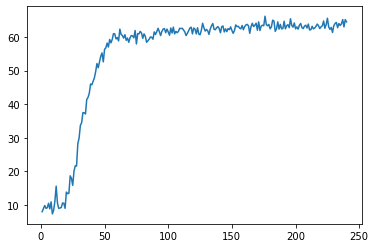

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb320211225115138.pkl
